# Cats vs Dogs

In [44]:
# standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import cv2

# keras packages
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import History, TensorBoard
import tensorflow as tf

# sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Images

In [5]:
train_path = '/mnt/DataDisk/jodahr/data/catsVsDogs/train_min/'
val_path = '/mnt/DataDisk/jodahr/data/catsVsDogs/validation/'

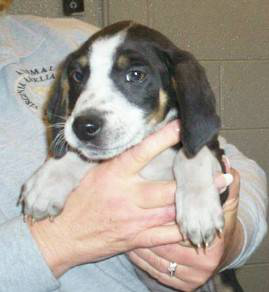

In [6]:
dog = load_img(train_path + 'dogs/dog.10.jpg')
dog

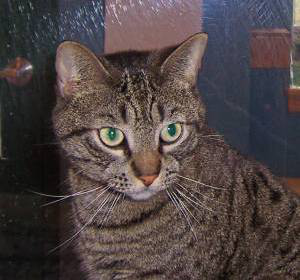

In [7]:
cat = load_img(train_path + 'cats/cat.1.jpg')
cat

In [8]:
cat_arr = img_to_array(cat)
dog_arr = img_to_array(dog)

In [9]:
cat_arr.shape

(280, 300, 3)

In [10]:
dog_arr.shape

(292, 269, 3)

#### resize

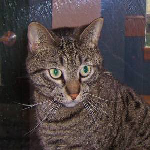

In [8]:
cat = load_img(train_path + 'cats/cat.1.jpg', target_size=(150,150))
cat

### data augmentation

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [12]:
# transform to rank/dim for input
# Insert a new axis that will appear at the axis position in the expanded array shape.
x = np.expand_dims(cat_arr, axis=0)
x.shape

(1, 280, 300, 3)

In [13]:
for i in range(10):
    augmented_arr = datagen.flow(x, batch_size=1).next()
    augmented_img = array_to_img(np.squeeze(augmented_arr, axis=0))
    augmented_img.save('/mnt/DataDisk/jodahr/data/catsVsDogs/augmented/' + str(i) + '.png')

## Image Data Generator for Training and Validation

In [14]:
print(x[0,:,:,:].max())
print(x[0,:,:,:].min())

255.0
0.0


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, # to scale between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## Keras Model

In [139]:
img_width = 150
img_height = 150

In [160]:
# to adjust for the backend (here tensorflow)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [161]:
input_shape

(150, 150, 3)

- **Convolution**: Clever reduction of dimensions via Matrix Multiplication
- **MaxPooling**: transforms e.g. 2x2 pixel matrix to the maximum pixel value

In [171]:
model = Sequential()

In [172]:
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [173]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [174]:
# loads 50 images into memory; propagates forwards and backwards (updating weights) using 1 batch
batch_size = 100
epochs = 50

In [175]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [176]:
nb_train_samples = 2000
nb_validation_samples = 800

In [177]:
# callbacks
history = History()
tb = TensorBoard()

### train on gpu

In [178]:
with tf.device('/gpu:0'):
    model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [history, tb])

Epoch 1/50
20/20 [==============================] - 16s 776ms/step - loss: 0.7763 - acc: 0.5170 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 2/50
20/20 [==============================] - 9s 475ms/step - loss: 0.6911 - acc: 0.5335 - val_loss: 0.6868 - val_acc: 0.5250
Epoch 3/50
20/20 [==============================] - 10s 510ms/step - loss: 0.6800 - acc: 0.5535 - val_loss: 0.6595 - val_acc: 0.6050
Epoch 4/50
20/20 [==============================] - 10s 508ms/step - loss: 0.6628 - acc: 0.5995 - val_loss: 0.6616 - val_acc: 0.5787
Epoch 5/50
20/20 [==============================] - 10s 504ms/step - loss: 0.6501 - acc: 0.6225 - val_loss: 0.6317 - val_acc: 0.6400
Epoch 6/50
20/20 [==============================] - 10s 509ms/step - loss: 0.6521 - acc: 0.6110 - val_loss: 0.6311 - val_acc: 0.6337
Epoch 7/50
20/20 [==============================] - 10s 513ms/step - loss: 0.6297 - acc: 0.6315 - val_loss: 0.6177 - val_acc: 0.6362
Epoch 8/50
20/20 [==============================] - 10s 496ms/step - l

In [25]:
model.save('model.h5')

In [16]:
model = load_model('model.h5')

In [179]:
model.layers

In [122]:
from vis.visualization import visualize_cam, get_num_filters, overlay, saliency, visualize_activation, visualize_saliency
from matplotlib import pyplot as plt

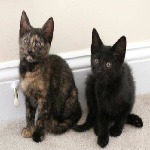

In [220]:
dog = load_img('/mnt/DataDisk/jodahr/data/catsVsDogs/validation/cats/cat.9640.jpg', target_size=(150,150))
dog

In [221]:
from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [222]:
dog_arr = img_to_array(dog) * 1./255.

In [223]:
dog_arr_exp = np.expand_dims(dog_arr, axis=0)
dog_arr_exp.shape

(1, 150, 150, 3)

In [224]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 64)        18496     
__________

In [225]:
cam_array = visualize_cam(model, 14, filter_indices=[0], seed_input=dog_arr_exp)

In [226]:
sal_array = visualize_saliency(model, 14, filter_indices=None, seed_input=dog_arr_exp)

In [227]:
get_num_filters(model.layers[8])

64

In [228]:
%matplotlib inline

In [229]:
cam_array.shape

(150, 150, 3)

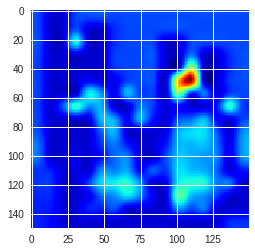

In [230]:
plt.imshow(cam_array, interpolation='nearest')

In [231]:
cam_array.shape

(150, 150, 3)

In [232]:
dog_arr_exp[0,:,:,:].shape

(150, 150, 3)

In [233]:
overlay_img = overlay(cam_array,dog_arr_exp[0,:,:,:],  alpha=1)

In [234]:
model.predict(dog_arr_exp)

array([[ 0.99704641,  0.00295364]], dtype=float32)

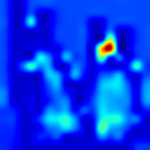

In [235]:
array_to_img(overlay_img)

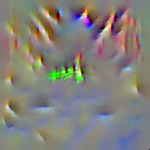

In [236]:
array_to_img(act_arry)

In [136]:
act_arry = visualize_activation(model, layer_idx=10, filter_indices=[1], seed_input=None)

In [131]:
sns.heatmap(overlay_img)

ValueError: Must pass 2-d input

In [46]:
#cv2.imwrite('source_img.png', deprocess_input(dog_arr_exp)[0])
cv2.imwrite('attention_map.png', cam_array)

True

In [ ]:
cv2.

In [106]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
 heatmap = visualize_cam(model,layer_idx=layer_idx, filter_indices=0,

                                seed_input=X,

                                penultimate_layer_idx=penultimater_layer_idx,

                                backprop_modifier=None,

                                grad_modifier=None)

        print("heatmap shape: ", heatmap.shape)

        cv2.imwrite('source_img.png', deprocess_input(X)[0])

        cv2.imwrite('attention_map.png', heatmap)